# Inferring Rings in Crops

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage mrspuff typing_extensions -q --upgrade

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
import espiownage
from espiownage.core import *
sysinfo()
print(f"espiownage version {espiownage.__version__}")

TORCH_VERSION=torch1.9.0; CUDA_VERSION=cu111
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 3080
hostname: bengio
espiownage version 0.0.41


In [ ]:
from fastai.vision.all import *

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize, ResizeMethod
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

from mrspuff.utils import on_colab

In [ ]:
on_colab = on_colab()

if on_colab:
    path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cleaner.tgz') / 'crops'
else:
    path = Path('/home/shawley/datasets/espiownage-cleaner/crops') 

print(path)

/home/shawley/datasets/espiownage-cleaner/crops


## Define the Original dls
To set up the dataloader.... this isn't technically necessary but it's the only way I know how. 

In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
print(fnames[ind])

def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                    get_items=get_image_files,
                    splitter=RandomSplitter(),
                    get_y=label_func,
                    item_tfms=Resize(cropsize, ResizeMethod.Squish),
                    batch_tfms=[*aug_transforms(size=cropsize, flip_vert=True, max_rotate=360.0), 
                    Normalize.from_stats(*imagenet_stats)])

dls = croppedrings.dataloaders(path, bs=32)

6614 total cropped images
/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00618_0_36_76_255_11.0.png
11.0


/home/shawley/envs/espi/lib/python3.6/site-packages/torch/_tensor.py:1023: UserWarning:

torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)



## Define the model & load weights

In [ ]:
opt = ranger
y_range=(0.2,13)  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlinearity
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, 
                    loss_func=MSELossFlat(), opt_func=opt)
learn.load('crop-rings-real_k0')

## Do the predictions

30980 image crops to predict on.


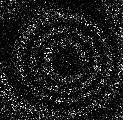

In [ ]:
crop_dir = 'crops_iv'  
pfnames = sorted(glob.glob(crop_dir+'/*.png')) # files to predict on
print(f"{len(pfnames)} image crops to predict on.")

# pick one and look at it
ind = len(pfnames)//4
pf = pfnames[ind]
im = PILImage.create(pf)
im 

In [ ]:
# new test dataloader
dlpred = dls.test_dl(pfnames)

# do the inference
preds, _ = learn.get_preds(dl=dlpred)

# inspect what we got, and 
print(preds.shape)
preds = preds.squeeze(1)
print(preds.shape)

torch.Size([30980, 1])
torch.Size([30980])


In [ ]:
preds = preds.cpu().numpy()
preds

array([ 7.3373857,  7.6905074,  4.5563207, ...,  4.4069023,  4.370282 ,
       10.989752 ], dtype=float32)

## Now what?

save a CSV, send it on

In [ ]:
# col_names = ['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle']

results = []
for i, pfile in enumerate(pfnames):
    rings = preds[i]
    pfile = str(Path(pfile).stem)
    splits = pfile.split('_')
    filename = splits[0]+'_proc_'+splits[2]+'.png'
    bbox = [int(x) for x in splits[3:]]
    cx, cy = (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2
    a, b, = bbox[2]-bbox[0], bbox[3]-bbox[1]
    angle = 0   # because who knows, right?
    line_list = [cx, cy, filename, rings, a, b, angle, bbox]
    results.append(line_list)

In [ ]:
# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle', 'bbox'])
print(len(res_df))
res_df.head()

30980


,cx,cy,filename,rings,a,b,angle,bbox
0,74.0,154.0,06240907_proc_00243.png,7.337386,140,242,0,"[4, 33, 144, 275]"
1,77.0,160.0,06240907_proc_00244.png,7.690507,140,256,0,"[7, 32, 147, 288]"
2,46.5,169.0,06240907_proc_00250.png,4.556321,93,248,0,"[0, 45, 93, 293]"
3,94.5,221.5,06240907_proc_00252.png,2.292115,135,153,0,"[27, 145, 162, 298]"
4,98.5,216.0,06240907_proc_00261.png,2.989285,145,152,0,"[26, 140, 171, 292]"


In [ ]:
abbrev_df = res_df[['cx', 'cy', 'filename', 'rings', 'a', 'b', 'angle']]
abbrev_df.head()
abbrev_df.to_csv('espiownage-ml-annotations.csv', index=False)

## Explore the Data

In [ ]:
df = res_df # more convenient name 

In [ ]:
def is_in_box(
    p,     # a point as a (x,y) coordinate pair 
    bb,    # a bounding box of the form [xmin,ymin,xmax,ymax]
    ):
    "Is this point within that bounding box?"
    x, y = p 
    return (x>=bb[0]) and (x<=bb[2]) and (y>=bb[1]) and (y<=bb[3])

In [ ]:
assert is_in_box((100,100),(10,30,180,50)) == False
assert is_in_box((100,100),(10,30,180,150)) == True

In [ ]:
# pick a point
p = (216, 139)  # same example as segmentation regression
df['p_in_box'] = [is_in_box(p,x) for x in df['bbox']]
print(f"We have {df['p_in_box'].sum()} bounding boxes (i.e frames) containing that point")
#df['haverings'] = truelines
df['rings_at_p'] = df['p_in_box']*df['rings']
df.tail()

We have 3831 bounding boxes (i.e frames) containing that point


,cx,cy,filename,rings,a,b,angle,bbox,p_in_box,rings_at_p,framenum
30975,42.5,135.0,06241902_proc_01997.png,11.092749,83,196,0,"[1, 37, 84, 233]",False,0.000000,13997
30976,44.0,140.5,06241902_proc_01998.png,11.158328,88,201,0,"[0, 40, 88, 241]",False,0.000000,13998
30977,196.5,142.5,06241902_proc_01998.png,4.406902,143,137,0,"[125, 74, 268, 211]",True,4.406902,13998
30978,195.5,140.5,06241902_proc_01999.png,4.370282,149,145,0,"[121, 68, 270, 213]",True,4.370282,13999
30979,44.5,141.0,06241902_proc_01999.png,10.989752,87,206,0,"[1, 38, 88, 244]",False,0.000000,13999


In [ ]:
fs_imgdir = '/home/shawley/datasets/zooniverse_steelpan/' # where all full size images are stored
imlist = [os.path.basename(x) for x in sorted(glob.glob(fs_imgdir+'/*.png'))]

fn_to_frame = lambda s: imlist.index(s)
fn_to_frame('06241902_proc_01997.png')

13997

In [ ]:
df['framenum'] = df['filename'].apply(fn_to_frame)

In [ ]:
df.head()

,cx,cy,filename,rings,a,b,angle,bbox,p_in_box,rings_at_p,framenum
0,74.0,154.0,06240907_proc_00243.png,7.337386,140,242,0,"[4, 33, 144, 275]",False,0.0,243
1,77.0,160.0,06240907_proc_00244.png,7.690507,140,256,0,"[7, 32, 147, 288]",False,0.0,244
2,46.5,169.0,06240907_proc_00250.png,4.556321,93,248,0,"[0, 45, 93, 293]",False,0.0,250
3,94.5,221.5,06240907_proc_00252.png,2.292115,135,153,0,"[27, 145, 162, 298]",False,0.0,252
4,98.5,216.0,06240907_proc_00261.png,2.989285,145,152,0,"[26, 140, 171, 292]",False,0.0,261


In [ ]:
plotdf = np.array(df[['framenum','rings_at_p']])
r_vs_t = np.zeros(df['framenum'].max()+1)
for (fn,r) in zip(df['framenum'],df['rings_at_p']):
    r_vs_t[fn] = r

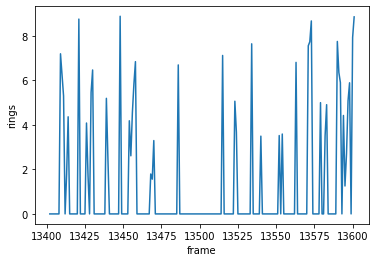

In [ ]:
start, end = 13502-100, 13502+100
plt.plot(range(start,end),r_vs_t[start:end])
plt.ylabel('rings')
plt.xlabel('frame')
plt.show()